## Imports and inits

In [1]:
import os, re, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn import image
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.image import load_img, resample_to_img

In [2]:
BASE = "/local/anpa/ds003242-1.0.0"
DERIVATIVES = f"{BASE}/derivatives/"
DERIVATIVES_FMRIPREP = f"{DERIVATIVES}/fmriprep/" 
DERIV_OUT = f"{DERIVATIVES}/firstlevel/"  
TASK = "CIC"
TR = 2.0

In [3]:
COND_MAP = {"b":"baseline", "f":"fasting", "s":"isolation"}

NUIS = ["framewise_displacement",
        "a_comp_cor_00","a_comp_cor_01","a_comp_cor_02",
        "a_comp_cor_03","a_comp_cor_04","a_comp_cor_05"]

## Utils

In [4]:
def fprep_func_dir(sub):
    return Path(BASE)/f"derivatives/fmriprep/sub-{sub}/func"


def collect_runs(sub, task):
    func = fprep_func_dir(sub)
    patt = func.glob(f"sub-{sub}_task-{task}_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
    runs = []
    for p in sorted(patt):
        m = re.search(r"_run-(\d+)_", p.name)
        if m: runs.append(m.group(1))
    return runs


def files_for(sub, task, run):
    func = fprep_func_dir(sub)
    bold = func/f"sub-{sub}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    conf = func/f"sub-{sub}_task-{task}_run-{run}_desc-confounds_regressors.tsv"
    evt  = Path(BASE)/f"sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_events.tsv"
    return bold, conf, evt


def load_confounds_list(conf_paths):
    out=[]
    for cp in conf_paths:
        df = pd.read_csv(cp, sep="\t").fillna(0)
        for c in NUIS:
            if c not in df: df[c]=0.0
        out.append(df[NUIS])
    return out


In [5]:
def resample_mask_to_bold(anat_mask, bold_img):
    """Resample anat mask to the space of the bold image.
    As in tutorial https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html
    """
    return resample_to_img(
        anat_mask,
        bold_img,
        interpolation="nearest",
        copy_header=True,
        force_resample=True,
    )


In [6]:
def fit_subject_condition(sub, tr=TR, smoothing=6.0):
    """Fit one GLM across all runs (block-diagonal) for a subject (which already encodes condition by suffix)."""
    runs = collect_runs(sub, TASK) 
    assert len(runs)>0, f"No runs for {sub} {TASK}"
    bolds, events, confs = [], [], []
    for r in runs:
        b, c, e = files_for(sub, TASK, r)
        if not (b.exists() and c.exists() and e.exists()):
            print(f"skip run {r} for {sub}: missing files"); continue
        bolds.append(str(b));  events.append(pd.read_csv(e, sep="\t")); confs.append(str(c))
    conf_list = load_confounds_list(confs)

    anat_mask  = f'{DERIVATIVES_FMRIPREP}/sub-{sub}/anat/sub-{sub}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
    
    resampled_anat_mask = resample_mask_to_bold(
        load_img(anat_mask),
        load_img(bolds[0])
    ) 

    glm = FirstLevelModel(
        t_r=tr, hrf_model="spm", drift_model="cosine", high_pass=0.008,
        noise_model="ar1", smoothing_fwhm=smoothing, standardize=False,
        mask_img=resampled_anat_mask, minimize_memory=False,  n_jobs=2
    ).fit(run_imgs=bolds, events=events, confounds=conf_list)
    return glm

## Contrasts to dict, allign with design matrix


In [7]:
all_sub_dirs = sorted([p.name.split("sub-")[-1] for p in Path(DERIVATIVES_FMRIPREP).glob("sub-*") if p.is_dir()])
all_sub_dirs[:3]

['SAXSISO01b', 'SAXSISO01f', 'SAXSISO01s']

In [8]:
for sub_sess in all_sub_dirs:
    print(f"Processing {sub_sess}")
    glm = fit_subject_condition(sub_sess) # all 6 runs
    break

Processing SAXSISO01b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

In [9]:
design_matrix = glm.design_matrices_[0]
design_matrix

,Control_1,Control_2,Control_3,Food_1,Food_2,Food_3,Rating,Social_1,Social_2,Social_3,...,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05,drift_1,drift_2,drift_3,drift_4,constant
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.121125,-0.107836,0.002380,-0.097117,0.010765,0.116636,0.116616,0.116582,0.116536,1.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.032763,-0.084530,0.109629,-0.068618,0.012454,0.116582,0.116403,0.116103,0.115685,1.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.033646,-0.058669,0.168545,-0.035175,-0.046992,0.116476,0.115977,0.115147,0.113989,1.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,-0.083057,-0.002278,0.206864,-0.094748,-0.002758,0.116316,0.115340,0.113718,0.111460,1.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,-0.018369,0.068244,0.236396,-0.006087,-0.006007,0.116103,0.114491,0.111821,0.108118,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007643,0.0,0.0,0.071873,...,-0.021950,0.056029,-0.015193,-0.001781,0.039326,-0.116103,0.114491,-0.111821,0.108118,1.0
286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191185,0.0,0.0,-0.094928,...,0.015491,0.067640,-0.064732,0.049984,0.005030,-0.116316,0.115340,-0.113718,0.111460,1.0
288.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591326,0.0,0.0,-0.143481,...,0.012504,0.096465,-0.054503,-0.001642,0.062214,-0.116476,0.115977,-0.115147,0.113989,1.0
290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.865152,0.0,0.0,-0.132109,...,0.011162,0.065295,-0.038983,0.000239,0.083097,-0.116582,0.116403,-0.116103,0.115685,1.0


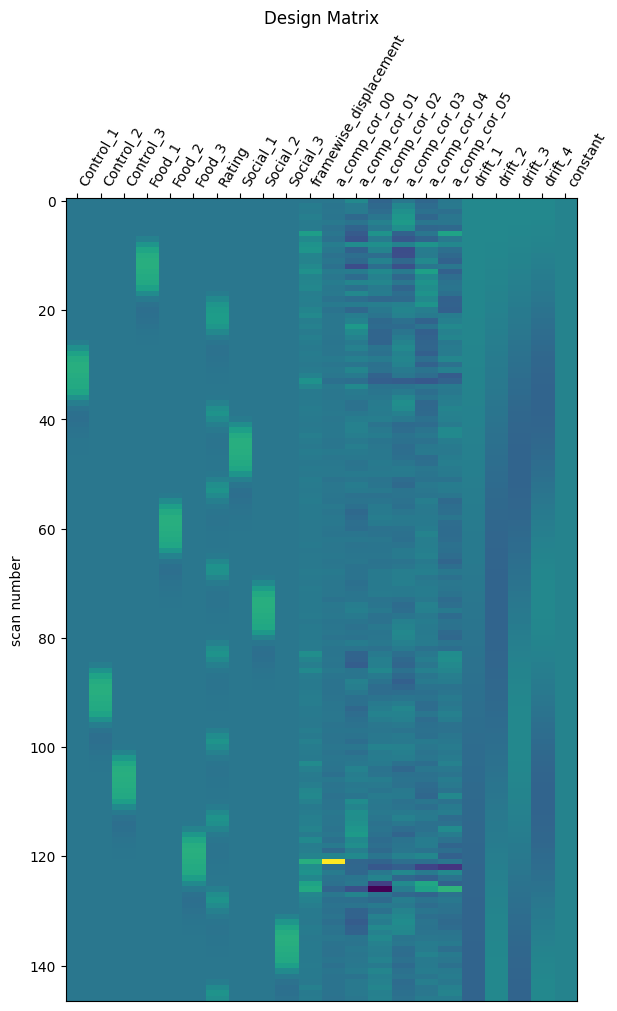

In [10]:
plot_design_matrix(design_matrix)
plt.title("Design Matrix")
plt.show()

In [11]:
contrast_file = "contrasts.tsv"
contrast_df = pd.read_csv(contrast_file, sep='\t', header=0)
contrast_df.reset_index(inplace=True)
contrast_df.rename(columns={'level_0': 'session'}, inplace=True)
contrast_df = contrast_df.query('session == @TASK')
design_cols = design_matrix.columns.tolist()

contrast_df

,session,level_1,task,desc,conds,weights
0,CIC,food_gt_control,Food_1 Food_2 Food_3 Control_1 Control_2 Contr...,0.3333 0.3333 0.3333 -0.3333 -0.3333 -0.3333,NaN,NaN
1,CIC,food_gt_rest,Food_1 Food_2 Food_3,0.3333 0.3333 0.3333,NaN,NaN
2,CIC,social_gt_control,Social_1 Social_2 Social_3 Control_1 Control_2...,0.3333 0.3333 0.3333 -0.3333 -0.3333 -0.3333,NaN,NaN
3,CIC,social_gt_rest,Social_1 Social_2 Social_3,0.3333 0.3333 0.3333,NaN,NaN
4,CIC,control_gt_food,Food_1 Food_2 Food_3 Control_1 Control_2 Contr...,-0.3333 -0.3333 -0.3333 0.3333 0.3333 0.3333,NaN,NaN
5,CIC,control_gt_rest,Control_1 Control_2 Control_3,0.3333 0.3333 0.3333,NaN,NaN
6,CIC,control_gt_social,Social_1 Social_2 Social_3 Control_1 Control_2...,-0.3333 -0.3333 -0.3333 0.3333 0.3333 0.3333,NaN,NaN
7,CIC,food_gt_social,Food_1 Food_2 Food_3 Social_1 Social_2 Social_3,0.3333 0.3333 0.3333 -0.3333 -0.3333 -0.3333,NaN,NaN
8,CIC,social_gt_food,Food_1 Food_2 Food_3 Social_1 Social_2 Social_3,-0.3333 -0.3333 -0.3333 0.3333 0.3333 0.3333,NaN,NaN
9,CIC,rating_gt_rest,Rating,1,NaN,NaN


In [12]:
# Final output dictionary
contrasts = {}

# Loop through each row in the contrast dataframe
for _, row in contrast_df.iterrows():
    contrast_name = row['level_1']
    
    # Skip if either task or desc is missing
    if pd.isna(row['task']) or pd.isna(row['desc']):
        print(f"⚠️ Skipping {contrast_name}: missing task or desc")
        continue

    # Parse the regressors and weights
    regressors = row['task'].split()
    weights = list(map(float, row['desc'].split()))
    
    if len(regressors) != len(weights):
        print(f"❌ Length mismatch in {contrast_name}: {len(regressors)} regressors vs {len(weights)} weights")
        continue

    # Initialize full contrast vector
    contrast_vec = np.zeros(len(design_cols))

    # Fill in the weights at the correct indices
    for reg, weight in zip(regressors, weights):
        if reg in design_cols:
            idx = design_cols.index(reg)
            contrast_vec[idx] = weight
        else:
            print(f"⚠️ Skipping regressor {reg} in {contrast_name} (not in design matrix)")

    # Add to the contrast dictionary
    contrasts[contrast_name] = contrast_vec

contrasts

{'food_gt_control': array([-0.3333, -0.3333, -0.3333,  0.3333,  0.3333,  0.3333,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ]),
 'food_gt_rest': array([0.    , 0.    , 0.    , 0.3333, 0.3333, 0.3333, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]),
 'social_gt_control': array([-0.3333, -0.3333, -0.3333,  0.    ,  0.    ,  0.    ,  0.    ,
         0.3333,  0.3333,  0.3333,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ]),
 'social_gt_rest': array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.3333,
        0.3333, 0.3333, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]),
 'control_gt_food': array([ 0.3333,  0.3333,  0.3333, -0.3

## Toy run for 1 participant

In [14]:
anat_mask = load_img(f"/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/anat/sub-SAXSISO01b_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")
bold_img = load_img(f"/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")

In [ ]:
anat_mask = load_img(f"/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/anat/sub-SAXSISO01b_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")
bold_img = load_img(f"/local/anpa/ds003242-1.0.0/derivatives/fmriprep/sub-SAXSISO01b/func/sub-SAXSISO01b_task-CIC_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
resampled_mask = resample_to_img(
    anat_mask,
    bold_img,
    interpolation="nearest",
    copy_header=True,
    force_resample=True,
)
resampled_mask

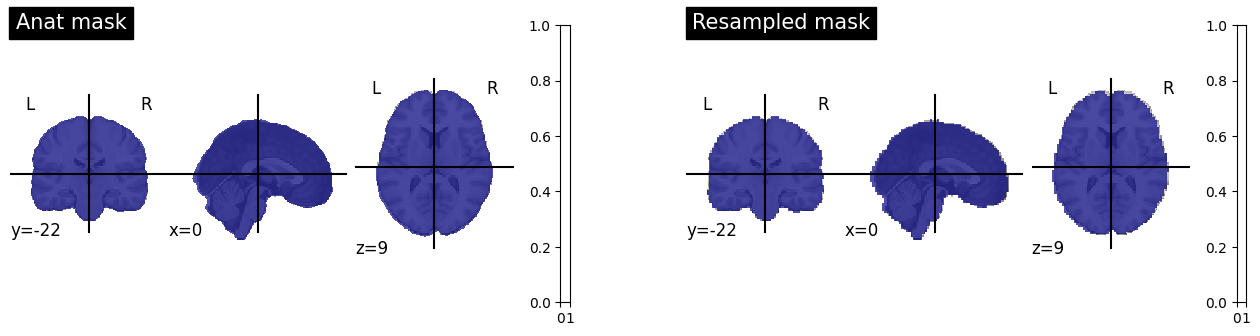

In [18]:

from nilearn.plotting import plot_roi

plt.figure(figsize=(16, 4))
ax = plt.subplot(121)
plot_roi(anat_mask, title="Anat mask", axes=ax)
ax = plt.subplot(122)
plot_roi(resampled_mask, title="Resampled mask", axes=ax)
plt.show()

In [19]:
def fit_subject_condition(sub, tr=TR, smoothing=6.0):
    """Fit one GLM across all runs (block-diagonal) for a subject (which already encodes condition by suffix)."""
    runs = collect_runs(sub, TASK) 
    assert len(runs)>0, f"No runs for {sub} {TASK}"
    bolds, masks, events, confs = [], [], [], []
    for r in runs:
        b, m, c, e = files_for(sub, TASK, r)
        if not (b.exists() and m.exists() and c.exists() and e.exists()):
            print(f"skip run {r} for {sub}: missing files"); continue
        bolds.append(str(b)); masks.append(str(m)) ; events.append(pd.read_csv(e, sep="\t")); confs.append(str(c))
    conf_list = load_confounds_list(confs)
    mask_img = resampled_mask  # Use the resampled anat mask for all runs
    glm = FirstLevelModel(
        t_r=tr, hrf_model="spm", drift_model="cosine", high_pass=0.008,
        noise_model="ar1", smoothing_fwhm=smoothing, standardize=False,
        mask_img=mask_img, minimize_memory=False
    ).fit(run_imgs=bolds, events=events, confounds=conf_list)
    return glm

In [21]:
for sub_sess in all_sub_dirs:
    print(f"Processing {sub_sess}")
    glm = fit_subject_condition(sub_sess) # all 6 runs
    break

Processing SAXSISO01b


/tmp/ipykernel_2683711/3965044741.py:13: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2683711/3965044741.py:13: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2683711/3965044741.py:13: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2683711/3965044741.py:13: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2683711/3965044741.py:13: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2683711/3965044741.py:13: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2683711/39

In [22]:
for name, vec in contrasts.items():
    print(f"Processing contrast {name} with vector {vec}")
    eff = glm.compute_contrast(vec, output_type="all")

Processing contrast food_gt_control with vector [-0.3333 -0.3333 -0.3333  0.3333  0.3333  0.3333  0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.    ]


/tmp/ipykernel_2683711/3807048195.py:3: UserWarning: One contrast given, assuming it for all 6 runs
  eff = glm.compute_contrast(vec, output_type="all")


Processing contrast food_gt_rest with vector [0.     0.     0.     0.3333 0.3333 0.3333 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.    ]
Processing contrast social_gt_control with vector [-0.3333 -0.3333 -0.3333  0.      0.      0.      0.      0.3333  0.3333
  0.3333  0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.    ]
Processing contrast social_gt_rest with vector [0.     0.     0.     0.     0.     0.     0.     0.3333 0.3333 0.3333
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.    ]
Processing contrast control_gt_food with vector [ 0.3333  0.3333  0.3333 -0.3333 -0.3333 -0.3333  0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.    ]
Processing contrast control_gt_rest with vector [0.3333 0.3333 0.3333 0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     

In [23]:
eff

{'z_score': <nibabel.nifti1.Nifti1Image at 0x7f5258e5dd30>,
 'stat': <nibabel.nifti1.Nifti1Image at 0x7f5258e5dbe0>,
 'p_value': <nibabel.nifti1.Nifti1Image at 0x7f51a7667640>,
 'effect_size': <nibabel.nifti1.Nifti1Image at 0x7f5258e5dd00>,
 'effect_variance': <nibabel.nifti1.Nifti1Image at 0x7f5258e5da60>}

In [24]:
thresholded_map, threshold = threshold_stats_img(
    eff['z_score'], alpha=0.05, height_control='fdr'
)
print(f"FDR-corrected threshold: {threshold}")

FDR-corrected threshold: 3.0178152890035106


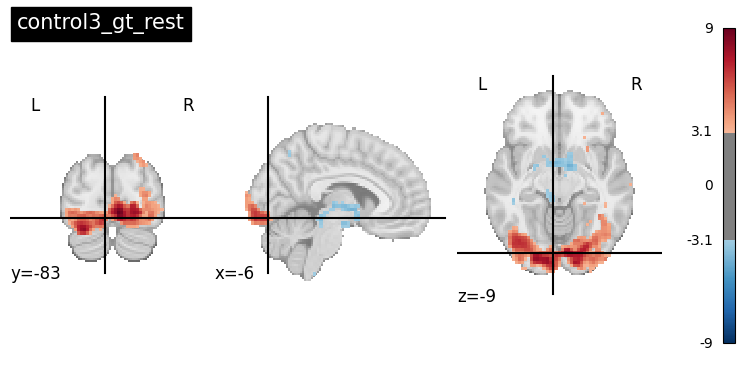

In [25]:
plot_stat_map(eff['z_score'], title=name, threshold=3.1)

# Positive values → food > control.
# Negative values → control > food.

# There are positive clusters (red/yellow) in ventral visual stream and possibly orbitofrontal cortex 
# (areas often associated with reward and food processing).
# There are negative clusters (blue) in other regions — meaning control images evoked stronger responses there.

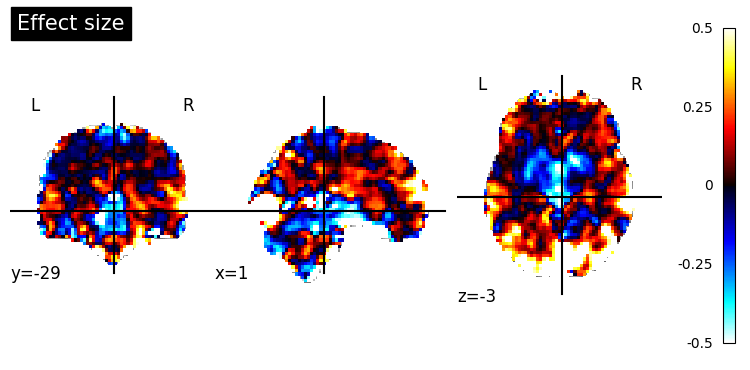

In [26]:
plotting.plot_stat_map(eff['effect_size'], title='Effect size',
                       vmax=0.5, vmin=-0.5, cmap='cold_hot')


In [27]:
report = glm.generate_report(
    contrasts=contrasts,  # your contrast vector or its name if using design matrix labels
)
report.save_as_html('anat_mask_glm_report_food_gt_control.html')

/tmp/ipykernel_2683711/3570569719.py:1: UserWarning: One contrast given, assuming it for all 6 runs
  report = glm.generate_report(


## Run all participants

In [13]:
def save_subject_condition_contrasts(outdir, glm, contrasts):
    for name, vec in contrasts.items():
        eff = glm.compute_contrast(vec, output_type="all") 
        eff['effect_size'].to_filename(outdir / f"{name}_effsize.nii.gz")
        eff['effect_variance'].to_filename(outdir / f"{name}_effvar.nii.gz")
        eff['z_score'].to_filename(outdir / f"{name}_zmap.nii.gz")
    # Save the report
    report = glm.generate_report(contrasts=contrasts)
    report.save_as_html(outdir / 'report.html')

In [ ]:
# Let's run the same contrast on all subjects

for sub_sess in all_sub_dirs:
    outdir = Path(DERIV_OUT)/f"sub-{sub_sess}"
    if not outdir.exists():
        outdir.mkdir()
        print(f"Processing {sub_sess}")
        glm = fit_subject_condition(sub_sess) # all 6 runs
        save_subject_condition_contrasts(outdir, glm, contrasts)

Processing SAXSISO32b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO32f


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO32s


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO33b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO33f


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO33s


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO34b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO34f


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO34s


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO35b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO35f


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO35s


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO36b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO36f


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO36s


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11

Processing SAXSISO38b


/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/1186814393.py:20: UserWarning: The following unexpected columns in events data will be ignored: weight
  glm = FirstLevelModel(
/tmp/ipykernel_2254952/11